<a href="https://colab.research.google.com/github/carlosflores597/SOM_WRF/blob/main/SOM_WRF_Andes_Amazon_Ecuador_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Universidad San Francisco de Quito

##Carlos Alberto Flores Cadena
## José David Vega


#1. Carga de librerías e instalación de paquetes necesarios.

##1.1. Instalación de Paquetes

In [ ]:
# Instalación de paquetes
!pip install mpi4py
!pip install numpy cython wheel
!pip install somoclu
!pip install gdown

# Importación de librerías
import somoclu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import math
import datetime
import tempfile
import gdown


from google.colab import drive
import ipywidgets as widgets
from IPython.display import display


##1.2. Montaje de Google Drive para acceder a la base de datos.

In [ ]:
# Monta Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. Entrenamiento del SOM con datos del 2019.

#2.1. Carga de datos WRF 2019.

In [ ]:
# ID del archivo de Google Drive
file_id = "1WAV9g_6gh30NU10jgZt03M5blu624wTG"
# Nombre del archivo local
output = "2019.csv"

# Descargar el archivo (maneja el aviso de virus automáticamente)
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# Cargar el archivo CSV descargado
df_2019 = pd.read_csv(output)

# Mostrar las primeras filas
print(df_2019.head())

Downloading...
From (original): https://drive.google.com/uc?id=1WAV9g_6gh30NU10jgZt03M5blu624wTG
From (redirected): https://drive.google.com/uc?id=1WAV9g_6gh30NU10jgZt03M5blu624wTG&confirm=t&uuid=60580ed7-8010-41a8-be82-85df721e5839
To: /content/2019.csv
100%|██████████| 28.3G/28.3G [04:13<00:00, 112MB/s] 


   Unnamed: 0  year  month  day  hour  pixel_x  pixel_y       TSK     EMISS  \
0           0  2019      1    1     1        0        0 -0.716480  0.012027   
1           1  2019      1    1     1        1        0 -0.743165  0.014724   
2           2  2019      1    1     1        2        0 -0.721277  0.014292   
3           3  2019      1    1     1        3        0 -0.729539  0.017604   
4           4  2019      1    1     1        4        0 -0.732516  0.018144   

      SWDOWN       GLW    GRDFLX        T2      PSFC        Q2  
0  23.886840  0.178058  0.065081  2.964229  2.775225  1.016485  
1  23.889832  0.178076  0.064859  2.964546  2.756854  1.154535  
2  23.884232  0.178018  0.065178  2.963422  2.766573  1.132387  
3  23.931900  0.178457  0.065660  2.971770  2.788848  1.118170  
4  23.929932  0.178437  0.065907  2.971392  2.804164  0.941584  


##2.2. Normalización de los datos.

In [ ]:
# Archivo de salida de coeficientes de normalización
coeff_path = '/content/drive/My Drive/SOM_model_2/202403_7days.coeffs'   #CAMBIAR ESTE DIRECTORIO DE ACUERDO CON SU NECESIDAD



ntype = 0  # 0 para normalización entre 0 y 1; -1 para -1 a 1
write_coeffs = True  # Escribir los coeficientes de normalización (en caso de requerirlos para uso posterior)

# Función para normalizar una columna del DataFrame
def normalize_column(column, ntype=0):
    minn = column.min()
    maxx = column.max()

    if maxx == minn:
        scale = 0.0
        c = 0.0
    else:
        scale = (1.0 - ntype) / float((maxx - minn))
        c = ntype - scale * minn

    normalized_column = column * scale + c

    return normalized_column, scale, c

# Función para escribir coeficientes de normalización a un archivo
def write_coefficients(coeff_path, coefficients):
    with open(coeff_path, 'w') as cfile:
        for var_name, (scale, c) in coefficients.items():
            cfile.write(f'{var_name},{scale},{c}\n')

# Diccionario para almacenar los coeficientes de normalización
coefficients = {}

# Lista de variables que se van a normalizar
variables = ['TSK', 'EMISS', 'SWDOWN', 'GLW', 'GRDFLX', 'T2', 'PSFC', 'Q2']

# Normalizar cada columna en el DataFrame
for var in variables:
    if var in df_2019.columns:
        df_2019[f'{var}_norm'], scale, c = normalize_column(df_2019[var], ntype)
        if write_coeffs:
            coefficients[var] = (scale, c)
        print(f'Normalized {var}', file=sys.stderr)

# Guardar los coeficientes de normalización (en caso de necesitarlos)
if write_coeffs:
    write_coefficients(coeff_path, coefficients)
    print(f'Coeficientes de normalización guardados en: {coeff_path}', file=sys.stderr)

# Mostrar las primeras filas del DataFrame normalizado
print(df_2019.head())

Normalized TSK
Normalized EMISS
Normalized SWDOWN
Normalized GLW
Normalized GRDFLX
Normalized T2
Normalized PSFC


   Unnamed: 0  year  month  day  hour  pixel_x  pixel_y       TSK     EMISS  \
0           0  2019      1    1     1        0        0 -0.716480  0.012027   
1           1  2019      1    1     1        1        0 -0.743165  0.014724   
2           2  2019      1    1     1        2        0 -0.721277  0.014292   
3           3  2019      1    1     1        3        0 -0.729539  0.017604   
4           4  2019      1    1     1        4        0 -0.732516  0.018144   

      SWDOWN  ...      PSFC        Q2  TSK_norm  EMISS_norm  SWDOWN_norm  \
0  23.886840  ...  2.775225  1.016485  0.632823    0.267886     0.885543   
1  23.889832  ...  2.756854  1.154535  0.598372    0.276023     0.885641   
2  23.884232  ...  2.766573  1.132387  0.626630    0.274721     0.885457   
3  23.931900  ...  2.788848  1.118170  0.615964    0.284716     0.887028   
4  23.929932  ...  2.804164  0.941584  0.612120    0.286345     0.886963   

   GLW_norm  GRDFLX_norm   T2_norm  PSFC_norm   Q2_norm  
0  0.80108

Normalized Q2
Coeficientes de normalización guardados en: /content/drive/My Drive/SOM_model_2/202403_7days.coeffs


##2.3. Aplicación del paquete SOMoclu


In [ ]:
# ---- Integración con SOMoclu ----

# Extraemos las columnas normalizadas del DataFrame
data = df_2019[[f'{var}_norm' for var in variables if f'{var}_norm' in df_2019.columns]].values

# Función para inicializar el SOM
def init_SOM(params):
    return somoclu.Somoclu(params.cols, params.rows,
                           initialcodebook=params.initial_codebook,
                           kerneltype=params.kerneltype,
                           maptype=params.maptype,
                           gridtype=params.gridtype,
                           compactsupport=params.compact_support,
                           neighborhood=params.neighborhood,
                           std_coeff=params.std_coeff,
                           initialization=params.initialization,
                           verbose=params.verbose,
                           vect_distance=params.vect_distance)

# Función para entrenar el SOM
def train_SOM(som, pixels, params):
    som.train(pixels,
              epochs=params.epochs,
              radius0=params.radius0,
              radiusN=params.radiusN,
              radiuscooling=params.radius_cooling,
              scale0=params.scale0,
              scaleN=params.scaleN,
              scalecooling=params.scale_cooling)
    print('SOM CODEBOOK:\n', som.codebook, file=sys.stderr)

# Agregar columna de clasificación al DataFrame original
def add_classification_to_df(som, df_2019, variables):
    # Extraer la activación de las neuronas (activación map o código de clasificación)
    codebook = som.codebook
    labels = np.zeros((df_2019.shape[0],))  # Inicializamos la columna de etiquetas de clasificación

    # Obtenemos los datos normalizados para clasificarlos
    data = df_2019[[f'{var}_norm' for var in variables if f'{var}_norm' in df_2019.columns]].values

    # Para cada fila de datos, asignamos una etiqueta de la neurona más cercana
    for i, sample in enumerate(data):
        # Calculamos la distancia entre el sample y cada neurona del SOM
        distances = np.linalg.norm(codebook.reshape(-1, codebook.shape[-1]) - sample, axis=1)
        # La neurona más cercana define la etiqueta
        labels[i] = np.argmin(distances)

    # Agregamos la nueva columna de clasificación al DataFrame original
    df_2019['SOM_Classification'] = labels
    return df_2019

# Clase con los parámetros del SOM
class somo_parameters:
    def __init__(self):
        self.cols = 6  # grid de nodos
        self.rows = 6
        self.kerneltype = 0  # 0 -> CPU; 1 -> GPU
        self.maptype = 'planar'
        self.gridtype = 'rectangular'
        self.compact_support = False
        self.neighborhood = 'bubble'
        self.std_coeff = 1.0
        self.verbose = 2
        self.epochs = 10  # número de épocas
        self.radius0 = 2.5
        self.radiusN = 0.5
        self.radius_cooling = 'linear'
        self.scale0 = 0.5
        self.scaleN = 0.01
        self.scale_cooling = 'linear'
        self.calc_errors = False
        self.apply_classes = True
        self.codebook_prefix = './somo_map'
        self.initial_codebook = None
        self.use_initial_codebook = False
        self.initialization = 'pca'
        self.vect_distance = 'euclidean'

    # Método para imprimir los parámetros
    def print_params(self, nfile=sys.stderr):
        print(f'cols= {self.cols}', file=nfile)
        print(f'rows= {self.rows}', file=nfile)
        print(f'kerneltype= {self.kerneltype}', file=nfile)
        print(f'maptype= {self.maptype}', file=nfile)
        print(f'gridtype= {self.gridtype}', file=nfile)
        print(f'compact support= {self.compact_support}', file=nfile)
        print(f'neighborhood= {self.neighborhood}', file=nfile)
        print(f'std_coeff= {self.std_coeff}', file=nfile)
        print(f'verbose= {self.verbose}', file=nfile)
        print(f'epochs= {self.epochs}', file=nfile)
        print(f'radius0= {self.radius0}', file=nfile)
        print(f'radiusN= {self.radiusN}', file=nfile)
        print(f'radius_cooling= {self.radius_cooling}', file=nfile)
        print(f'scale0= {self.scale0}', file=nfile)
        print(f'scaleN= {self.scaleN}', file=nfile)
        print(f'scale_cooling= {self.scale_cooling}', file=nfile)
        print(f'calculate_errors= {self.calc_errors}', file=nfile)
        print(f'apply_classes= {self.apply_classes}', file=nfile)
        print(f'initial_codebook= {self.initial_codebook}', file=nfile)
        print(f'use_initial_codebook= {self.use_initial_codebook}', file=nfile)
        print(f'initialization= {self.initialization}', file=nfile)
        print(f'vector distance measure= {self.vect_distance}', file=nfile)
        print(f'codebook_prefix= {self.codebook_prefix}', file=nfile)

# Función para inicializar y entrenar el SOM
def run_SOM(df_2019, variables):
    params = somo_parameters()
    params.print_params(sys.stderr)  # Mostramos los parámetros de entrenamiento

    som = init_SOM(params)

    # Extraemos las columnas normalizadas del DataFrame para entrenar el SOM
    data = df_2019[[f'{var}_norm' for var in variables if f'{var}_norm' in df_2019.columns]].values

    # Entrenamos el SOM con los datos normalizados
    train_SOM(som, data, params)

    print('SOM entrenamiento completado.')

    # Clasificamos los datos y agregamos la clasificación al DataFrame original
    df_2019 = add_classification_to_df(som, df_2019, variables)

    return df_2019, som

# Ejecutar la clasificación SOM y agregarla al DataFrame
df_2019, som = run_SOM(df_2019, variables)

# Mostrar las primeras filas del DataFrame con la clasificación
print(df_2019.head())

cols= 6
rows= 6
kerneltype= 0
maptype= planar
gridtype= rectangular
compact support= False
neighborhood= bubble
std_coeff= 1.0
verbose= 2
epochs= 10
radius0= 2.5
radiusN= 0.5
radius_cooling= linear
scale0= 0.5
scaleN= 0.01
scale_cooling= linear
calculate_errors= False
apply_classes= True
initial_codebook= None
use_initial_codebook= False
initialization= pca
vector distance measure= euclidean
codebook_prefix= ./somo_map


SOM CODEBOOK:
 [[[1.         0.4534875  1.         0.88006264 1.         0.7934602
   0.91160893 0.07319603]
  [1.         0.50001574 1.         0.5979153  1.         0.53191984
   0.6700537  0.09828848]
  [0.52846014 0.26423234 0.619308   0.52846014 0.9039106  0.52846014
   0.52846014 0.0389074 ]
  [0.6341983  0.5834068  0.76715606 0.6268542  0.9275893  0.6012647
   0.5602893  0.07670905]
  [0.7199677  0.2948768  0.40591964 0.26604667 0.3966475  0.23873807
   0.2606995  0.06948509]
  [0.8178626  0.30344975 0.37562892 0.21802898 0.3081296  0.19599365
   0.20044467 0.34910938]]

 [[0.54831636 0.255461   0.5        0.3722812  0.5        0.33289844
   0.37149128 0.06398307]
  [0.6529904  0.4481788  0.6209421  0.4431605  0.69043785 0.41401783
   0.4014121  0.0865456 ]
  [0.68190753 0.27476013 0.6457554  0.48469332 0.7304769  0.4368454
   0.5081921  0.05111872]
  [0.6032227  0.34548995 0.76887    0.70167255 0.8629368  0.67451656
   0.6693125  0.04778801]
  [1.         0.5009164  1.         

SOM entrenamiento completado.
   Unnamed: 0  year  month  day  hour  pixel_x  pixel_y       TSK     EMISS  \
0           0  2019      1    1     1        0        0 -0.716480  0.012027   
1           1  2019      1    1     1        1        0 -0.743165  0.014724   
2           2  2019      1    1     1        2        0 -0.721277  0.014292   
3           3  2019      1    1     1        3        0 -0.729539  0.017604   
4           4  2019      1    1     1        4        0 -0.732516  0.018144   

      SWDOWN  ...        Q2  TSK_norm  EMISS_norm  SWDOWN_norm  GLW_norm  \
0  23.886840  ...  1.016485  0.632823    0.267886     0.885543  0.801083   
1  23.889832  ...  1.154535  0.598372    0.276023     0.885641  0.801187   
2  23.884232  ...  1.132387  0.626630    0.274721     0.885457  0.800858   
3  23.931900  ...  1.118170  0.615964    0.284716     0.887028  0.803353   
4  23.929932  ...  0.941584  0.612120    0.286345     0.886963  0.803242   

   GRDFLX_norm   T2_norm  PSFC_norm   

##2.4. Graficamos la calsificación de los distintos píxeles.

In [ ]:
def plot_heatmap(day):
    df_filtered = df_2019[(df_2019['day'] == day) & (df_2019['hour'] == 4)]

    if df_filtered.empty:
        print(f"No hay datos disponibles para el día {day}.")
        return

    # Obtener dimensiones de la matriz
    pixel_x_max = df_filtered['pixel_x'].max() + 1
    pixel_y_max = df_filtered['pixel_y'].max() + 1

    # Crear una matriz vacía para la visualización
    matrix = np.full((pixel_y_max, pixel_x_max), np.nan)

    # Llenar la matriz con los valores de SOM_labels
    for _, row in df_filtered.iterrows():
        matrix[int(row['pixel_y']), int(row['pixel_x'])] = row['SOM_Classification']

    # Crear la figura con una mejor paleta de colores y sin líneas blancas
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap="viridis", cbar=True, square=True, linewidths=0,
                cbar_kws={"shrink": 0.8, "label": "Clases SOM"}, annot=False)

    # Configurar etiquetas y título
    plt.title(f"Clasificación ETO WRF - 2019", fontsize=14)
    plt.xlabel("Lon")
    plt.ylabel("Lat")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Definir rango de días
day_min = df_2019['day'].min()
day_max = df_2019['day'].max()

# Crear widget Play con diseño minimalista
play = widgets.Play(
    value=0,
    min=0,
    max=729,
    step=1,
    interval=1000,
    description="Press play",
    disabled=False
)

# Crear slider oculto (sin descripción y sin mostrarse)
slider = widgets.IntSlider(min=day_min, max=day_max, step=1, value=day_min, layout=widgets.Layout())

# Sincronizar Play con el slider
widgets.jslink((play, 'value'), (slider, 'value'))

# Mostrar solo los controles en estilo minimalista
display(play)

# Vincular la función con el slider oculto
widgets.interactive(plot_heatmap, day=slider)


Play(value=0, description='Press play', interval=1000, max=729)

interactive(children=(IntSlider(value=1, description='day', max=31, min=1), Output()), _dom_classes=('widget-i…

##2.5. Gráfico de distorsión (QE) por mes

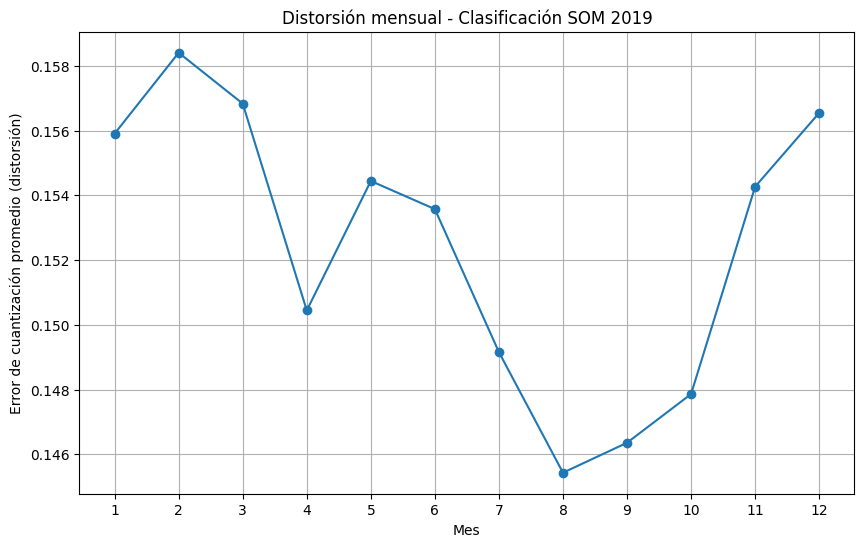

In [ ]:
def compute_monthly_distortion(df, som, variables):
    # Extraer el codebook como matriz 2D (num_neuronas x num_features)
    codebook = som.codebook.reshape(-1, som.codebook.shape[-1])

    monthly_distortion = {}

    for month in sorted(df['month'].unique()):
        df_month = df[df['month'] == month]

        if df_month.empty:
            continue

        data_month = df_month[[f'{var}_norm' for var in variables if f'{var}_norm' in df_month.columns]].values
        labels_month = df_month['SOM_Classification'].astype(int).values

        # Calcular la distorsión como la distancia euclidiana al codebook de cada muestra
        distances = np.linalg.norm(data_month - codebook[labels_month], axis=1)
        distortion = np.mean(distances)
        monthly_distortion[month] = distortion

    return monthly_distortion

# Calcular distorsión mensual
monthly_distortion = compute_monthly_distortion(df_2019, som, variables)

# Graficar la distorsión mensual
plt.figure(figsize=(10, 6))
plt.plot(list(monthly_distortion.keys()), list(monthly_distortion.values()), marker='o', linestyle='-')
plt.title("Distorsión mensual - Clasificación SOM 2019")
plt.xlabel("Mes")
plt.ylabel("Error de cuantización promedio (distorsión)")
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()


##2.4. Guardamos el modelo para aplicarlo a los otros periodos de tiempo

In [ ]:
# Crear carpeta
output_dir = '/content/drive/My Drive/SOM_model_2' #CAMBIAR ESTE DIRECTORIO DE ACUERDO A SU NECESIDAD
os.makedirs(output_dir, exist_ok=True)
# Guardar el codebook del SOM entrenado
np.save('/content/drive/My Drive/SOM_model_2/somo_codebook_2019.npy', som.codebook) #CAMBIAR ESTE DIRECTORIO DE ACUERDO A SU NECESIDAD
print("Codebook guardado exitosamente.")


Codebook guardado exitosamente.


#3. Aplicación del SOM previamente entrenado a los datos del 2018

##3.1. Carga de datos WRF 2018.

In [ ]:
# ID del archivo
file_id = "1q7iV-NjDsdxm5HIDLJrPSYX2ljkaLB8L"
# Nombre del archivo que se guardará localmente
output = "2018.csv"

# Descargar desde Google Drive usando gdown
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)
# Cargar los datos del 2018
df_2018 = pd.read_csv(output)

# Normalizar usando los mismos coeficientes del 2018
for var in variables:
    if var in df_2018.columns and var in coefficients:
        scale, c = coefficients[var]
        df_2018[f'{var}_norm'] = df_2018[var] * scale + c
        print(f'Normalized {var} for 2018', file=sys.stderr)

Normalized TSK for 2018
Normalized EMISS for 2018
Normalized SWDOWN for 2018
Normalized GLW for 2018
Normalized GRDFLX for 2018
Normalized T2 for 2018
Normalized PSFC for 2018
Normalized Q2 for 2018


##3.2. Aplicación del modelo SOM , previamente entrenado, a los datos del año 2018.

In [ ]:
# Cargar el codebook previamente guardado
codebook_2019 = np.load('/content/drive/My Drive/SOM_model_2/somo_codebook_2019.npy')

# Clasificar con el codebook cargado
def classify_with_loaded_codebook(df, codebook, variables):
    labels = np.zeros((df.shape[0],))
    data = df[[f'{var}_norm' for var in variables if f'{var}_norm' in df.columns]].values

    for i, sample in enumerate(data):
        distances = np.linalg.norm(codebook.reshape(-1, codebook.shape[-1]) - sample, axis=1)
        labels[i] = np.argmin(distances)

    df['SOM_Classification'] = labels
    return df

df_2018 = classify_with_loaded_codebook(df_2018, codebook_2019, variables)

# Mostrar resultado
print(df_2018.head())


   Unnamed: 0  year  month  day  hour  pixel_x  pixel_y       TSK     EMISS  \
0           0  2018      1    1     1        0        0 -0.707811  0.011084   
1           1  2018      1    1     1        1        0 -0.732995  0.014725   
2           2  2018      1    1     1        2        0 -0.711049  0.014352   
3           3  2018      1    1     1        3        0 -0.718651  0.017921   
4           4  2018      1    1     1        4        0 -0.721379  0.018377   

      SWDOWN  ...        Q2  TSK_norm  EMISS_norm  SWDOWN_norm  GLW_norm  \
0  23.299500  ...  1.448150  0.644016    0.265039     0.866178  0.770221   
1  23.238144  ...  1.541427  0.611502    0.276028     0.864155  0.767046   
2  23.200043  ...  1.391676  0.639835    0.274901     0.862898  0.765068   
3  23.209122  ...  1.152817  0.630020    0.285670     0.863198  0.765514   
4  23.187592  ...  0.992115  0.626499    0.287046     0.862488  0.764403   

   GRDFLX_norm   T2_norm  PSFC_norm   Q2_norm  SOM_Classification  


##3.3. Graficamos la calsificación de los distintos píxeles.

In [ ]:
def plot_heatmap(day):
    df_filtered = df_2018[(df_2018['day'] == day) & (df_2018['hour'] == 4)]

    if df_filtered.empty:
        print(f"No hay datos disponibles para el día {day}.")
        return

    # Obtener dimensiones de la matriz
    pixel_x_max = df_filtered['pixel_x'].max() + 1
    pixel_y_max = df_filtered['pixel_y'].max() + 1

    # Crear una matriz vacía para la visualización
    matrix = np.full((pixel_y_max, pixel_x_max), np.nan)

    # Llenar la matriz con los valores de SOM_labels
    for _, row in df_filtered.iterrows():
        matrix[int(row['pixel_y']), int(row['pixel_x'])] = row['SOM_Classification']

    # Crear la figura con una mejor paleta de colores y sin líneas blancas
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap="viridis", cbar=True, square=True, linewidths=0,
                cbar_kws={"shrink": 0.8, "label": "Clases SOM"}, annot=False)

    # Configurar etiquetas y título
    plt.title(f"Clasificación ETO WRF - 2018", fontsize=14)
    plt.xlabel("Lon")
    plt.ylabel("Lat")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Definir rango de días
day_min = df_2018['day'].min()
day_max = df_2018['day'].max()

# Crear widget Play con diseño minimalista
play = widgets.Play(
    value=0,
    min=0,
    max=729,
    step=1,
    interval=1000,
    description="Press play",
    disabled=False
)

# Crear slider oculto (sin descripción y sin mostrarse)
slider = widgets.IntSlider(min=day_min, max=day_max, step=1, value=day_min, layout=widgets.Layout())

# Sincronizar Play con el slider
widgets.jslink((play, 'value'), (slider, 'value'))

# Mostrar solo los controles en estilo minimalista
display(play)

# Vincular la función con el slider oculto
widgets.interactive(plot_heatmap, day=slider)

Play(value=0, description='Press play', interval=1000, max=729)

interactive(children=(IntSlider(value=1, description='day', max=31, min=1), Output()), _dom_classes=('widget-i…

##3.4. Graficamos la distorsión (QE) mensual.

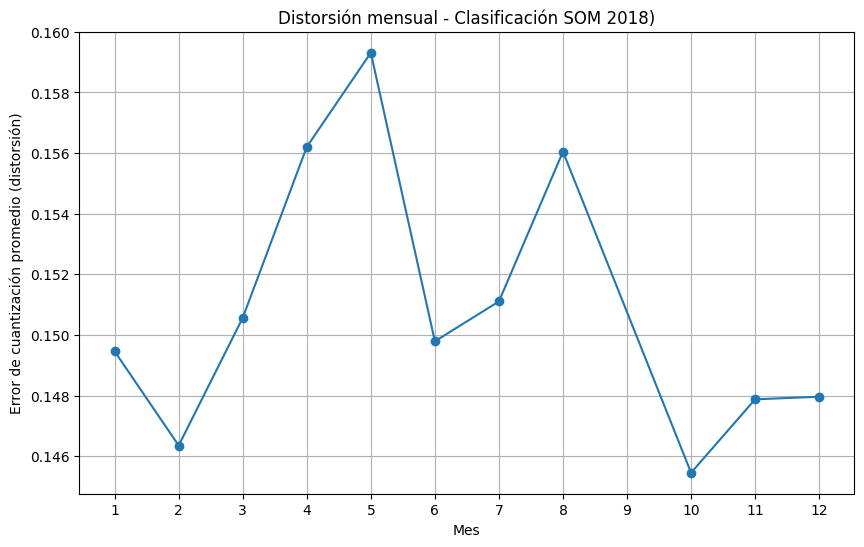

In [ ]:
def compute_monthly_distortion(df, codebook, variables):
    # Aplanar el codebook para facilitar el acceso
    codebook_flat = codebook.reshape(-1, codebook.shape[-1])

    monthly_distortion = {}

    for month in sorted(df['month'].unique()):
        df_month = df[df['month'] == month]

        if df_month.empty:
            continue

        data_month = df_month[[f'{var}_norm' for var in variables if f'{var}_norm' in df_month.columns]].values
        labels_month = df_month['SOM_Classification'].astype(int).values

        # Calcular distancias a las neuronas ganadoras
        distances = np.linalg.norm(data_month - codebook_flat[labels_month], axis=1)
        distortion = np.mean(distances)

        monthly_distortion[month] = distortion

    return monthly_distortion

# Calcular distorsión mensual
monthly_distortion_2018 = compute_monthly_distortion(df_2018, codebook_2019, variables)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(list(monthly_distortion_2018.keys()), list(monthly_distortion_2018.values()), marker='o', linestyle='-')
plt.title("Distorsión mensual - Clasificación SOM 2018)")
plt.xlabel("Mes")
plt.ylabel("Error de cuantización promedio (distorsión)")
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()


#4. Aplicación del SOM previamente entrenado a los datos del 2017.


##4.1. Carga de datos WRF 2017.

In [ ]:
# ID del archivo de Google Drive
file_id = "1baQdt5OISlfGqIm4aTdcQ8Pw6tWaH1RL"
output = "datos_2017.csv"  # Nombre del archivo guardado localmente

# Descargar el archivo
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# Leer el archivo CSV
df_2017 = pd.read_csv(outputde,limiter=',', on_bad_lines='skip')

# Lista de variables que se van a normalizar
variables = ['TSK', 'EMISS', 'SWDOWN', 'GLW', 'GRDFLX', 'T2', 'PSFC', 'Q2']


# Normalizar usando los mismos coeficientes del 2019
for var in variables:
    if var in df_2017.columns and var in coefficients:
        scale, c = coefficients[var]
        df_2017[f'{var}_norm'] = df_2017[var] * scale + c
        print(f'Normalized {var} for 2017', file=sys.stderr)

Normalized TSK for 2017
Normalized EMISS for 2017
Normalized SWDOWN for 2017
Normalized GLW for 2017
Normalized GRDFLX for 2017
Normalized T2 for 2017
Normalized PSFC for 2017
Normalized Q2 for 2017


##4.2. Aplicación del modelo SOM , previamente entrenado, a los datos del año 2017.

In [ ]:
# Cargar el codebook previamente guardado
codebook_2019 = np.load('/content/drive/My Drive/SOM_model_2/somo_codebook_2019.npy')

# Clasificar con el codebook cargado
def classify_with_loaded_codebook(df, codebook, variables):
    labels = np.zeros((df.shape[0],))
    data = df[[f'{var}_norm' for var in variables if f'{var}_norm' in df.columns]].values

    for i, sample in enumerate(data):
        distances = np.linalg.norm(codebook.reshape(-1, codebook.shape[-1]) - sample, axis=1)
        labels[i] = np.argmin(distances)

    df['SOM_Classification'] = labels
    return df

df_2017 = classify_with_loaded_codebook(df_2017, codebook_2019, variables)

# Mostrar resultado
print(df_2017.head())

   Unnamed: 0  year  month  day  hour  pixel_x  pixel_y       TSK     EMISS  \
0           0  2017      1    1     1        0        0 -0.713109  0.008098   
1           1  2017      1    1     1        1        0 -0.739125  0.009992   
2           2  2017      1    1     1        2        0 -0.717546  0.010815   
3           3  2017      1    1     1        3        0 -0.725131  0.014476   
4           4  2017      1    1     1        4        0 -0.727499  0.015358   

      SWDOWN  ...        Q2  TSK_norm  EMISS_norm  SWDOWN_norm  GLW_norm  \
0  23.876389  ...  1.106502  0.637176    0.256029     0.885198  0.800497   
1  23.791641  ...  1.160438  0.603587    0.261746     0.882404  0.795977   
2  23.731827  ...  1.065613  0.631447    0.264229     0.880432  0.792789   
3  23.703674  ...  0.938179  0.621654    0.275277     0.879504  0.791277   
4  23.648422  ...  0.850063  0.618597    0.277938     0.877682  0.788363   

   GRDFLX_norm   T2_norm  PSFC_norm   Q2_norm  SOM_Classification  


##4.3. Graficamos la clasificación de los distintos píxeles.

In [ ]:
def plot_heatmap(day):
    df_filtered = df_2017[(df_2017['day'] == day) & (df_2017['hour'] == 4)]

    if df_filtered.empty:
        print(f"No hay datos disponibles para el día {day}.")
        return

    # Obtener dimensiones de la matriz
    pixel_x_max = df_filtered['pixel_x'].max() + 1
    pixel_y_max = df_filtered['pixel_y'].max() + 1

    # Crear una matriz vacía para la visualización
    matrix = np.full((pixel_y_max, pixel_x_max), np.nan)

    # Llenar la matriz con los valores de SOM_labels
    for _, row in df_filtered.iterrows():
        matrix[int(row['pixel_y']), int(row['pixel_x'])] = row['SOM_Classification']

    # Crear la figura con una mejor paleta de colores y sin líneas blancas
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap="viridis", cbar=True, square=True, linewidths=0,
                cbar_kws={"shrink": 0.8, "label": "Clases SOM"}, annot=False)

    # Configurar etiquetas y título
    plt.title(f"Clasificación ETO WRF - 2017", fontsize=14)
    plt.xlabel("Lon")
    plt.ylabel("Lat")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Definir rango de días
day_min = df_2017['day'].min()
day_max = df_2017['day'].max()

# Crear widget Play con diseño minimalista
play = widgets.Play(
    value=0,
    min=0,
    max=729,
    step=1,
    interval=1000,
    description="Press play",
    disabled=False
)

# Crear slider oculto (sin descripción y sin mostrarse)
slider = widgets.IntSlider(min=day_min, max=day_max, step=1, value=day_min, layout=widgets.Layout())

# Sincronizar Play con el slider
widgets.jslink((play, 'value'), (slider, 'value'))

# Mostrar solo los controles en estilo minimalista
display(play)

# Vincular la función con el slider oculto
widgets.interactive(plot_heatmap, day=slider)

Play(value=0, description='Press play', interval=1000, max=729)

interactive(children=(IntSlider(value=1, description='day', max=31, min=1), Output()), _dom_classes=('widget-i…

##4.4. Graficamos la distorsión (QE) mensual.

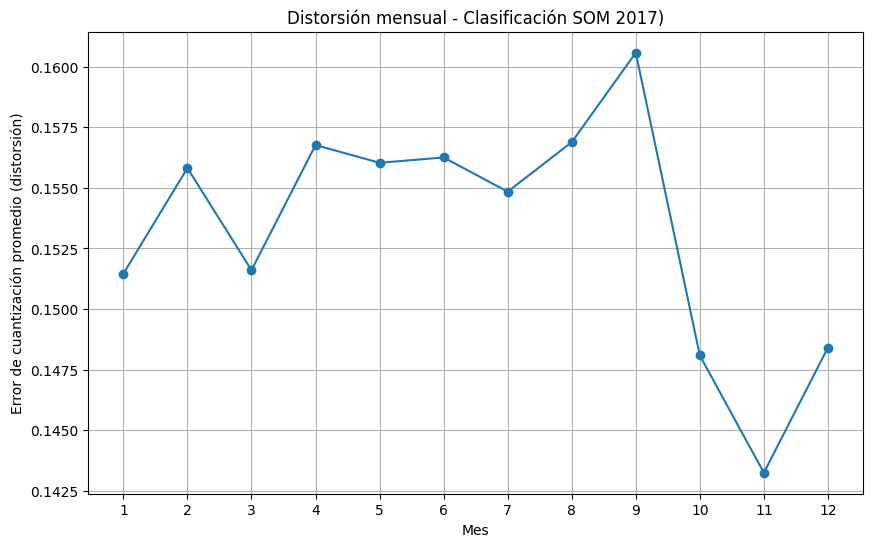

In [ ]:
def compute_monthly_distortion(df, codebook, variables):
    # Aplanar el codebook para facilitar el acceso
    codebook_flat = codebook.reshape(-1, codebook.shape[-1])

    monthly_distortion = {}

    for month in sorted(df['month'].unique()):
        df_month = df[df['month'] == month]

        if df_month.empty:
            continue

        data_month = df_month[[f'{var}_norm' for var in variables if f'{var}_norm' in df_month.columns]].values
        labels_month = df_month['SOM_Classification'].astype(int).values

        # Calcular distancias a las neuronas ganadoras
        distances = np.linalg.norm(data_month - codebook_flat[labels_month], axis=1)
        distortion = np.mean(distances)

        monthly_distortion[month] = distortion

    return monthly_distortion

# Calcular distorsión mensual
monthly_distortion_2017 = compute_monthly_distortion(df_2017, codebook_2019, variables)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(list(monthly_distortion_2017.keys()), list(monthly_distortion_2017.values()), marker='o', linestyle='-')
plt.title("Distorsión mensual - Clasificación SOM 2017)")
plt.xlabel("Mes")
plt.ylabel("Error de cuantización promedio (distorsión)")
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()